## PointNet to Classify Proteins

### Dataset study

In [9]:
# Getting the data
import os

#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import sys

home_path = '/home/giorgio/venvs/SHREC'
if home_path not in sys.path:
    sys.path.append(home_path)

from pandas import DataFrame
import pandas as pd

from pathlib import Path

from datasetStudy import *

debug_pointnet = False

# Multiple function here depends on this variable
#root = '/mnt/dataset/shrec-2025-protein-classification/v2-20250331' 
base_path = Path('/mnt/')
#base_path = Path('/mnt/raid1')
root = base_path / 'dataset/shrec-2025-protein-classification/v2-20250331'

#train_data = os.listdir(os.path.join(root, 'train'))
#train_data_cls = pd.read_csv('datasets/train_set-all.csv', sep=',', index_col=0)

train_data = os.listdir(root / 'train')
train_data_cls = pd.read_csv('../datasets/train_set-all.csv', sep=',', index_col=0)

print(train_data[:5])
print()
print(train_data_cls.info())
train_data_cls

['8ugd_8:R:3U_model1.vtk', '8h0v_18:R:c_model1.vtk', '3j3q_1:DX:4F_model1.vtk', '4u4u_23:XC:d1_model1.vtk', '6rny_4:H:H_model1.vtk']

<class 'pandas.core.frame.DataFrame'>
Index: 9244 entries, 0 to 9243
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   protein_id        9244 non-null   object
 1   class_id          9244 non-null   int64 
 2   number_of_points  9244 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 288.9+ KB
None


,protein_id,class_id,number_of_points
0,8ugd_8:R:3U_model1,96,5916
1,8h0v_18:R:c_model1,86,10078
2,3j3q_1:DX:4F_model1,8,18432
3,4u4u_23:XC:d1_model1,83,8242
4,6rny_4:H:H_model1,34,9204
...,...,...,...
9239,3j3y_1:HL:6R_model1,8,18342
9240,4u4y_15:O:C3_model1,91,12976
9241,7w31_26:AA:c_model1,18,16454
9242,3j4k_1:E:E_model1,90,23188


In [10]:
src = root / 'train-xz'
mountpoint = '/tmp/ramdrive'
size_in_gb = 3

def create_ramdrive(src, mountpoint, size_in_gb):
    if Path(mountpoint).exists() or Path(mountpoint).is_dir():
        print(f'Ramdrive already created, exiting...')
        return
    
    !sudo mkdir -p "{mountpoint}"
    !sudo mount -o size="{size_in_gb}"G -t tmpfs none "{mountpoint}"
    !rsync -a --progress "{src}" "{mountpoint}"
    
def unmount_ramdrive(mountpoint):
    !sudo umount "{mountpoint}"
    !sudo rmdir "{mountpoint}"

In [11]:
create_ramdrive(src, mountpoint, size_in_gb)
#unmount_ramdrive(mountpoint)

Ramdrive already created, exiting...


In [4]:
possible_disconnected_mesh(train_data_cls, 96, False)

disconnected_dict = {}
for idx in range(97):
    disconnected_dict[idx] = possible_disconnected_mesh(train_data_cls, idx)

#print(disconnected_dict)

_, damaged = possible_disconnected_mesh(train_data_cls, 8, True); damaged

,protein_id,class_id,number_of_points


In [5]:
dist = cls_distribution(train_data_cls)
inspect_distribution(dist, l_lim=0, u_lim=5)

Classes which have between 0 and 5 element: 16/97


#### Create and save new dataframe

In [6]:
dist_all = cls_distribution(train_data_cls)

# Filter the number of points
raw_train_dataframe_f1 = number_of_point_filter(train_data_cls, 1000)
dist_f1 = cls_distribution(raw_train_dataframe_f1)


# Filter according to the number of samples in classes
raw_train_dataframe_f2 = number_of_class_filter(raw_train_dataframe_f1, l_cut_off=10)
dist_f2 = cls_distribution(raw_train_dataframe_f2)

raw_train_dataframe_f3 = number_of_class_filter(raw_train_dataframe_f1, l_cut_off=10, u_cut_off=100)
dist_f3 = cls_distribution(raw_train_dataframe_f3)

raw_train_dataframe_f4 = number_of_class_filter(raw_train_dataframe_f1, l_cut_off=0, u_cut_off=200)
dist_f4 = cls_distribution(raw_train_dataframe_f4)

raw_train_dataframe_f5 = number_of_class_filter(raw_train_dataframe_f1, l_cut_off=100)
dist_f5 = cls_distribution(raw_train_dataframe_f5)

raw_train_dataframe_f6 = number_of_class_filter(raw_train_dataframe_f1, l_cut_off=0, u_cut_off=450)
dist_f6 = cls_distribution(raw_train_dataframe_f6)

distributions = [dist_all, dist_f1, dist_f2, dist_f3, dist_f4, dist_f5, dist_f6]
for idx in range(len(dist_all)):
    output = f'cls {idx}: '
    for dist in distributions:
        output += f'{print_dist(dist, idx)}\t'
    print(output)

print(f'{len(train_data_cls) = }')
print(f'{len(raw_train_dataframe_f1) = }')
print(f'{len(raw_train_dataframe_f2) = }')
print(f'{len(raw_train_dataframe_f3) = }')
print(f'{len(raw_train_dataframe_f4) = }')
print(f'{len(raw_train_dataframe_f5) = }')

cls 0: 101	101	101	0	101	101	101	
cls 1: 3	3	0	0	3	0	3	
cls 2: 17	17	17	17	17	0	17	
cls 3: 21	21	21	21	21	0	21	
cls 4: 15	15	15	15	15	0	15	
cls 5: 127	127	127	0	127	127	127	
cls 6: 25	25	25	25	25	0	25	
cls 7: 75	75	75	75	75	0	75	
cls 8: 2054	2054	2054	0	0	2054	0	
cls 9: 66	66	66	66	66	0	66	
cls 10: 14	14	14	14	14	0	14	
cls 11: 43	43	43	43	43	0	43	
cls 12: 10	10	10	10	10	0	10	
cls 13: 22	22	22	22	22	0	22	
cls 14: 489	489	489	0	0	489	0	
cls 15: 89	89	89	89	89	0	89	
cls 16: 154	154	154	0	154	154	154	
cls 17: 116	116	116	0	116	116	116	
cls 18: 76	76	76	76	76	0	76	
cls 19: 42	42	42	42	42	0	42	
cls 20: 7	7	0	0	7	0	7	
cls 21: 74	74	74	74	74	0	74	
cls 22: 58	58	58	58	58	0	58	
cls 23: 10	10	10	10	10	0	10	
cls 24: 10	10	10	10	10	0	10	
cls 25: 143	143	143	0	143	143	143	
cls 26: 2	2	0	0	2	0	2	
cls 27: 3	3	0	0	3	0	3	
cls 28: 18	18	18	18	18	0	18	
cls 29: 14	14	14	14	14	0	14	
cls 30: 3	3	0	0	3	0	3	
cls 31: 33	33	33	33	33	0	33	
cls 32: 93	93	93	93	93	0	93	
cls 33: 126	126	126	0	126	126	126	
cls 34: 73

In [7]:
cls_selected = [8, 90, 56, 14, 61, 70, 86, 5, 16, 25, 54, 62, 74, 83, 91, 92, 17, 45, 87, 71]

df_3 = create_dataframe(raw_train_dataframe_f1, class_ids=cls_selected[:2],  number_of_proteins=500)
df_4 = create_dataframe(raw_train_dataframe_f1, class_ids=cls_selected[:10], number_of_proteins=100)
df_5 = create_dataframe(raw_train_dataframe_f1, class_ids=cls_selected[:20], number_of_proteins=50)
df_6 = create_dataframe(raw_train_dataframe_f1, class_ids=cls_selected[:20], number_of_proteins=100)
#df_7 = create_dataframe(raw_train_dataframe_f6, class_ids=dist_f6_available_classes, number_of_proteins=100000)
df_8 = create_dataframe(raw_train_dataframe_f1, class_ids=[40, 88], number_of_proteins=10000)
df_9 = create_dataframe(raw_train_dataframe_f1, class_ids=[0, 1], number_of_proteins=1000)
df_10 = create_dataframe(raw_train_dataframe_f1, class_ids=[8,14], number_of_proteins=3000)
df_11 = create_dataframe(raw_train_dataframe_f4, class_ids=raw_train_dataframe_f4['class_id'].unique(), number_of_proteins=500)
'''
df_3.to_csv('datasets/train_set-2_cls-1000_images.csv')
df_4.to_csv('datasets/train_set-10_cls-1000_images.csv')
df_5.to_csv('datasets/train_set-20_cls-1000_images.csv')
df_6.to_csv('datasets/train_set-20_cls-2000_images.csv')
df_7.to_csv('datasets/train_set-all-cls_except-cls-larger-than-450.csv')
symmetria_df.to_csv('datasets/train_set-symmetria-100k-easy-astroid-citrus-10k-samples.csv')
df_8.to_csv('datasets/train_set-2_cls_40_88-192_proteins.csv')
df_9.to_csv('../datasets/train_set_unbalanced-2_cls_0_1.csv')
df_10.to_csv('../datasets/train_set_unbalanced-2_cls_8_14.csv')
df_11.to_csv('../datasets/train_set-small-cls.csv')
'''





"\ndf_3.to_csv('datasets/train_set-2_cls-1000_images.csv')\ndf_4.to_csv('datasets/train_set-10_cls-1000_images.csv')\ndf_5.to_csv('datasets/train_set-20_cls-1000_images.csv')\ndf_6.to_csv('datasets/train_set-20_cls-2000_images.csv')\ndf_7.to_csv('datasets/train_set-all-cls_except-cls-larger-than-450.csv')\nsymmetria_df.to_csv('datasets/train_set-symmetria-100k-easy-astroid-citrus-10k-samples.csv')\ndf_8.to_csv('datasets/train_set-2_cls_40_88-192_proteins.csv')\ndf_9.to_csv('../datasets/train_set_unbalanced-2_cls_0_1.csv')\ndf_10.to_csv('../datasets/train_set_unbalanced-2_cls_8_14.csv')\ndf_11.to_csv('../datasets/train_set-small-cls.csv')\n"

#### Visulize protein

In [8]:
cls_id = 1
df = raw_train_dataframe_f1[raw_train_dataframe_f1['class_id'] == cls_id]
print(len(df))
visualize_mesh(raw_train_dataframe_f1, cls=cls_id, idx=3)

3
PolyData (0x712fc8066200)
  N Cells:    11576
  N Points:   5788
  N Strips:   0
  X Bounds:   -1.384e+01, 1.552e+01
  Y Bounds:   -1.553e+01, 1.623e+01
  Z Bounds:   -1.842e+01, 2.068e+01
  N Arrays:   3


Widget(value='<iframe src="http://localhost:44055/index.html?ui=P_0x712fc8333950_0&reconnect=auto" class="pyvi…

### Augmentations

In [16]:
from format import Text
import torch
from symmetria.transformations import *
from symmetria.shapes import BenchmarkShape

In [17]:
points_rectangle = np.array([[0, 2, 0, 0, 2, 2, 0, 2],
                             [0, 0, 1, 0, 1, 0, 1, 1],
                             [0, 0, 0, 1, 0, 1, 1, 1]]).astype(np.float32)

points_rectangle_t = torch.from_numpy(points_rectangle)

rot = random_rotation_matrix(rotate_x=False, rotate_z=False)

shapebench = BenchmarkShape(points_rectangle_t)
#shapebench.apply_rotation(torch.from_numpy(rot))
#shapebench.apply_traslation(1,1,0)
#shapebench.apply_uniform_noise(100, 1)
#shapebench.apply_gaussian_noise(100, 1)

rect = pv.PolyData(shapebench.points.numpy().T)
#rect.plot()

In [18]:
from random import random

class RotateAroundZero():
    def __init__(self, p=0.5, rot=None):
        self.p = p
        self.rot = rot

    def __call__(self, points):
        if random() < self.p:
            if self.rot == None:
                rot = torch.from_numpy(random_rotation_matrix())
            else:
                rot = self.rot
        
            rot = rot.to(torch.device(points.device))

            ones = torch.ones((1,points.shape[0]), device=points.device)
            coords = torch.concatenate((torch.transpose(points, 0, 1), ones))
            
            coords = rot@coords
            
            points = torch.transpose(coords[:3,:], 0, 1)

        return points
    
    def __repr__(self):
        return f'RotateAroundZero(p={repr(self.p)}, rot={repr(self.rot)})'
    
class Translate():
    def __init__(self, p=0.5, shift=None, scale=1):
        self.p = p
        self.shift = shift
        self.scale = scale

    def __call__(self, points):        
        if random() < self.p:
            if self.shift == None:
                shift = (torch.rand(1, device=points.device) * self.scale,
                         torch.rand(1, device=points.device) * self.scale,
                         torch.rand(1, device=points.device) * self.scale)
            else:
                shift = self.shift
            
            for i in range(len(shift)):
                points[:,i] += shift[i]
                   
        return points
    
    def __repr__(self):
        return f'Translate(p={repr(self.p)}, shift={repr(self.shift)}, scale={repr(self.scale)})'
    
class UniformNoise():
    def __init__(self, n, T, p=0.5):
        self.p = p
        self.n, self.T = n, T
    
    def __call__(self, points):
        if random() < self.p:
            num_points = points.shape[0]

            indices = torch.randperm(num_points, device=points.device)[:self.T]

            points[indices,:] = points[indices,:] + (2*torch.rand(self.T, 3, device=points.device)-1)/self.n
        
        return points
    
    def __repr__(self):
        return f'UniformNoise(n={repr(self.n)}, T={repr(self.T)}, p={repr(self.p)})'
    
class GaussianNoise():
    def __init__(self, n, T, p=0.5):
        self.p = p
        self.n, self.T = n, T
    
    def __call__(self, points):
        if random() < self.p:
            num_points = points.shape[0]

            indices = torch.randperm(num_points, device=points.device)[:self.T]
    
            points[indices,:] = points[indices,:] + torch.rand(self.T, 3, device=points.device)/self.n

        return points
    
    def __repr__(self):
        return f'GaussianNoise(n={repr(self.n)}, T={repr(self.T)}, p={repr(self.p)})'

In [19]:
points_rectangle = np.array([[0, 2, 0, 0, 2, 2, 0, 2],
                             [0, 0, 1, 0, 1, 0, 1, 1],
                             [0, 0, 0, 1, 0, 1, 1, 1]]).astype(np.float32).T

points_rectangle_t = torch.from_numpy(points_rectangle).to(torch.device('cuda:0'))

translate = Translate(p=1)
print(translate)
points_rectangle_t = translate(points_rectangle_t)
print(translate)
rect = pv.PolyData(points_rectangle)
#rect.plot()

rect_tfm = pv.PolyData(points_rectangle_t.cpu().numpy())
#rect_tfm.plot()

Translate(p=1, shift=None, scale=1)
Translate(p=1, shift=None, scale=1)


### DataSet and DataLoader

#### Dataset

In [20]:
import numpy as np
import lzma
from torch.utils.data import Dataset, DataLoader
from symmetria.transforms.RandomSampler import RandomSampler
from symmetria.transforms.UnitSphereNormalization import UnitSphereNormalization
from tqdm import tqdm

class ProteinDataset(Dataset):
    def __init__(self, data_df, tfms, balancing='None', root=root, extention='xz', train=True):
        super().__init__()
        self.df = data_df
        self.tfms = tfms
        self.balancing = balancing
        self.extention = extention
        
        self.train = train
        if self.train:
            if self.extention == 'vtk':
                self.root = os.path.join(root, 'train')

            elif self.extention == 'xz':
                #self.root = os.path.join(root, 'train-symmetria-xz') # TODO roll back
                self.root = os.path.join(root, 'train-xz')
            else:
                raise UserWarning('Extention not supported')
            
        else:
            raise UserWarning('Not yet implemented for the test dataset')
        
        self.encode_label()
        self.loader()
    
    def loader(self):
        self.data = []
        
        # Defining the balancing factor for each class
        self.set_balancing()

        # Loading data
        for index in tqdm(self.df.index):
            protein, cls, nop = self.df['protein_id'].loc[index], self.df['class_id'].loc[index], self.df['number_of_points'].loc[index]

            cls_t = torch.tensor(self.encoded_cls[cls]).to(torch.device('cuda:0'))

            if self.extention == 'vtk':
                point_cloud = self.get_vtk_points(protein)

            elif self.extention == 'xz':
                point_cloud = self.get_xz_points(protein, cls, nop)

            point_cloud_t = torch.from_numpy(point_cloud).to(torch.device('cuda:0'))     

            point_cloud_t, cls_t = point_cloud_t.type(torch.float32), cls_t.type(torch.float32)
            
            for _ in range(self.balancing_factors[cls]):
                self.data.append((point_cloud_t, cls_t))

    def get_vtk_points(self, name):
        prot_file = name + '.' + self.extention
        prot_file = os.path.join(self.root, prot_file)
        
        prot_mesh = pv.read(prot_file)

        return prot_mesh.points

    def get_xz_points(self, name, cls, nop=None, debug=False):
        cls = str(cls)
        nop = str(nop) if nop and nop != 'nan' else None

        while len(cls) < 2:
            cls = '0' + cls
        
        if nop and nop != 'nan':
            while len(nop) < 6:
                nop = '0' + nop

        if nop and nop != 'nan':
            prot_file = cls + '-' + nop +  '-' + name.replace(':', '+') + '.' + self.extention
        else:
            prot_file = cls + '-' + name.replace(':', '+') + '.' + self.extention
        if debug:
            print(f'ProteinDataset is loading files from {self.root}')
        prot_file = os.path.join(self.root, prot_file)        
        
        with lzma.open(prot_file, 'rt') as f:
            point_cloud = np.loadtxt(f)

        return point_cloud

    def set_balancing(self):
        self.balancing_factors = {}
        dist = cls_distribution(self.df)
        for key, value in dist.items():
            if self.balancing == 'Proportional':
                self.balancing_factors[key] = max_of_dist(dist)//value
            
            elif self.balancing == 'Weak':
                factor = max_of_dist(dist)//value

                if factor < 10:
                    self.balancing_factors[key] = factor
                else:
                    self.balancing_factors[key] = int(10)

            elif self.balancing == 'None':
                self.balancing_factors[key] = int(1)
            
            else:
                raise(UserWarning(f'{self.balancing} is an invalid option'))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index, do_transform=True):
        prot, cls = self.data[index]
        
        if do_transform:
            for tfm in self.tfms:
                prot = tfm(prot)

        # NOTE: here we transpose the points (from Nx3 to 3xN) to then pass them to the PoinNet encoder
        prot = torch.transpose(prot, 0, 1)
        return (prot, cls)
    
    def encode_label(self):
        self.encoded_cls = {}
        
        prot_clss = np.sort(self.df['class_id'].unique())
        
        #One hot encoding
        '''
        for idx, cls in enumerate(prot_clss):
            self.encoded_cls[cls] = np.eye(len(prot_clss))[idx]
        '''

        for idx, cls in enumerate(prot_clss):
            self.encoded_cls[cls] = int(idx)

    def render_pointcloud(self, index):
        prot, _ = self.data[index]
        prot = torch.transpose(prot, 0, 1).numpy()
        cloud = pv.PolyData(prot)
        print(cloud)
        cloud.plot()
    

transforms = [UnitSphereNormalization(),
              Translate(p=0.8, scale=1),
              RotateAroundZero(p=0.8),
              GaussianNoise(n=100, T=2500, p=0.8),
              RandomSampler(sample_size=5000)]


def generate_train_valid_set(df, tfms, val_pct, root=root, seed=42, **kwargs):
    '''
    Can also take some other arguments to be passed to the dataset initializer

            -> path (str): path to the parent directory containing the train files 
    '''

    train_size = int(len(df) * (1 - val_pct))    
    df_train = df.sample(train_size, random_state=seed)
    df_valid = df.drop(df_train.index)

    return ProteinDataset(df_train, tfms, root=root, **kwargs), ProteinDataset(df_valid, tfms, root=root, **kwargs)

'''
def generate_train_valid_set_boring(df, val_pct, seed=42):
    train_size = int(len(df) * val_pct)    
    df_train = df.sample(train_size, random_state=seed)
    df_valid = df.drop(df_train.index)

    return df_train, df_valid
'''

'\ndef generate_train_valid_set_boring(df, val_pct, seed=42):\n    train_size = int(len(df) * val_pct)    \n    df_train = df.sample(train_size, random_state=seed)\n    df_valid = df.drop(df_train.index)\n\n    return df_train, df_valid\n'

#### Testing Dataset

In [ ]:
example_dataframe = create_dataframe(raw_train_dataframe_f1, class_ids=[2, 5, 30], number_of_proteins=100000)
example_set_train, example_set_valid = generate_train_valid_set(example_dataframe, transforms, 0.2, balancing=True)

In [ ]:
print(example_set_train.balancing_factors)
print(example_set_train.encoded_cls)
cls_distribution(example_set_train.df)

In [ ]:
example_set_train.__getitem__(0, do_transform=False)

In [ ]:
prot = example_set_train.__getitem__(0, do_transform=False)

In [ ]:
print(f'{Text(prot, 'prot'):content}')

In [ ]:
print(f'{Text(prot[0], 'prot[0]'):content}')

In [ ]:
print(f'{prot[0].min() = } - {prot[0].max() = }')

In [ ]:
unit_normalizer = UnitSphereNormalization()
prot, _ = example_set_train.__getitem__(0, do_transform=False)
prot = torch.transpose(prot, 0, 1)
norm_prot = unit_normalizer(prot)

In [ ]:
print(f'{Text(norm_prot, 'norm_prot'):content}')

In [ ]:
print(f'{norm_prot.min() = } - {norm_prot.max() = }')

In [ ]:
print(f'{unit_normalizer.centroid.min() = } - {unit_normalizer.centroid.max() = }')

In [ ]:
unit_normalizer.centroid.shape

In [ ]:
points = prot[0]

In [ ]:
points

### PointNet class

In [ ]:
import importlib
import symmetria
importlib.reload(symmetria)
importlib.reload(symmetria.decoders)
importlib.reload(symmetria.decoders.prediction_head)

#### PointNet

In [22]:
import torch.nn as nn
import torch.nn.functional as F
from symmetria.encoders.pointnet_encoder import PointNetEncoder
from symmetria.encoders.PointNetPlusPlusEncoder import PointNetPlusPlusEncoder

from symmetria.encoders.pointnext.pointnext_encoder_parameters import *
from symmetria.encoders.pointnext.pointnext_encoder import PointNeXt

from symmetria.decoders.prediction_head import PredictionHead

if debug_pointnet:
    bs, sz = 1, 2048
    encoder = PointNetEncoder(use_bn=False)
    mock_x = torch.randn(bs, 3, sz)
    output = encoder.forward(mock_x)
    print(f'{Text(output, 'output'):inspect}')

    decoder = PredictionHead(1024, 96)
    output_decoder = decoder.forward(output)
    print(f'{Text(output_decoder, 'output_decoder'):inspect}')

class PointNet(nn.Module):
    def __init__(self, output_size, max_points, use_bn=False, encoder='pointnet'): # make it prettier like in segmenter
        super().__init__()
        
        if encoder in POINTNEXT_MODEL_CONFIG:
            model_cfg = POINTNEXT_MODEL_CONFIG[encoder]     # 'PointNeXt_B' (21.5 M), 'PointNeXt_L2' (32.0 M), 'PointNeXt_XXL' (73.8 M)
            self.encoder = PointNeXt(model_cfg)
            self.encoder_output_size = output_size          # because of the adapter head (e.g. 2048 -> 1024) within the encoder
            print(f"Using PointNeXt {model_cfg} - encoder: {self.encoder}")
        elif encoder == 'pointnet':
            self.encoder = PointNetEncoder(use_bn)
            print(f"Using PointNet as encoder - encoder: {self.encoder}")
        elif encoder == 'pointnetplusplus':
            self.encoder = PointNetPlusPlusEncoder()
        
        self.max_points = max_points

        self.input_size = self.get_input_size()        
        self.output_size = output_size

        print(f'Creating a PredictionHead with {self.input_size} as input and {self.output_size} as output')
        self.decoder = PredictionHead(self.input_size, self.output_size, use_bn, use_relu=True)
        
        #self.softmax = nn.Softmax(dim=1)

    def get_input_size(self):
        mock_x = torch.randn(1, 3, self.max_points)
        return self.encoder(mock_x).shape[-1]

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        #x = self.softmax(x)

        return x #SoftMax already inside the CrossEntropyLoss

### Config Definition

In [23]:
from datetime import datetime
from torch import optim

time_now = datetime.now()
time_now = time_now.strftime('%d%m%Y_%H%M%S')
_folder = !pwd

env = {}

### Debug
env['debug_loss'] = False

env['project_folder'] = _folder[0]
env['project'] = 'shrec-2025'
env['run'] = env['project'] + '_' + time_now
#env['output_dir'] = os.path.join(env['project_folder'], 'wandb', 'run_' + env['run'])
if 'output' not in os.listdir(env['project_folder']):
    os.mkdir('output')
env['output_dir'] = Path(env['project_folder']) / 'output'

env['max_points'] = 4000

#env['dataset'] = 'train_set-2_cls-1000_images.csv' 
#env['dataset'] = 'train_set_comprehensive.csv'
env['dataset'] = 'train_set-all.csv'
#env['dataset'] = 'train_set-all-cls_except-cls-larger-than-450.csv'
#env['dataset'] = 'train_set-symmetria-100k-easy-astroid-citrus-10k-samples.csv'
#env['dataset'] = 'train_set-2_cls-1000_images.csv'
#env['dataset'] = 'train_set-10_cls-1000_images.csv'
#env['dataset'] = 'train_set_unbalanced-2_cls_0_1.csv'
#env['dataset'] = 'train_set_unbalanced-2_cls_8_14.csv'
#env['dataset'] = 'train_set-small-cls.csv'

#env['dataset_path'] = '/mnt/dataset/shrec-2025-protein-classification/v2-20250331'
env['dataset_path'] = root

'''
Balancing options:
    'Proportional'
        the balancing fatcor for each class is computed with respect to the class with more elements
    'Weak'
        same as 'Proportional' but with a cut off of 10 over the balancing factor
    'None'
        balancing factor fixed on 1 
'''
env['dataset_balancing'] = 'None'

ds_path = Path('../datasets') / env['dataset']
print(f'Creating a test dataset from {ds_path}')

test = pd.read_csv(ds_path, index_col=0)
print(f'Test dataset has {len(test)} rows')

Creating a test dataset from ../datasets/train_set-all.csv
Test dataset has 9244 rows


### Model Definition

In [24]:
env['device'] = 'cuda:0'
env['val_pct'] = 0.2
env['augmentations_on'] = True
'''
env['aug'] = [Translate(p=0.8),
              UnitSphereNormalization(),
              RotateAroundZero(p=0.8),
              GaussianNoise(n=10, T=(env['max_points']//2),  p=0.8),
              RandomSampler(sample_size=env['max_points'])]
'''

env['aug'] = [Translate(p=0.5),
              UnitSphereNormalization(),
              RotateAroundZero(p=0.5),
              RandomSampler(sample_size=env['max_points']),
              GaussianNoise(n=10, T=(env['max_points']//2),  p=0.5),
              ]

#env['aug'] = [UnitSphereNormalization()]
#env['aug'] = []

env['bs'] = 4
env['epochs'] = 100
env['lr'] = 1e-4
env['momentum'] = 0
#env['wd'] = 5e-2 # because "PointNeXt is trained with a weight decay of 0.05 for 250 epochs" - nope, too large, doesn't learn!
env['wd'] = 1e-3 # because of this: https://github.com/yanx27/Pointnet_Pointnet2_pytorch/blob/master/train_classification.py

env['encoder']   = 'pointnet'
#env['encoder']  = 'PointNeXt_XXL'
env['model']     = PointNet(output_size=len(test['class_id'].unique()), max_points=env['max_points'], encoder=env['encoder']).to(torch.device(env['device']))

env['model_pth'] = '/tmp/pointnet.pth'
env['pretrain']  = False

if env['pretrain']:
    if not Path(env['model_pth']).exists():
        !wget 'https://github.com/meder411/PointNet-PyTorch/raw/refs/heads/master/classifier_model_state.pth' --output-document "{env['model_pth']}"
    else:
        print(f'{env['model_pth']} already exists, skipping download...')
    
    print(f'Loading file {env['model_pth']}')
    env['model'].load_state_dict(torch.load(env['model_pth'], map_location=torch.device(env['device'])), strict=False)

env['epoch_checkpoints'] = 20
env['save_folder'] = env['output_dir']/Path(f'run_{env['run']}_{env['dataset'].split('.')[0]}')
print(f'Saving models checkpoints to {env['save_folder']}')

env['loss_func'] = nn.CrossEntropyLoss()
env['optimizer'] = optim.Adam(env['model'].parameters(), lr=env['lr'], weight_decay=env['wd'])
'''
env['optimizer'] = optim.SGD(env['model'].parameters(),
                             lr=env['lr'],
                             momentum=env['momentum'],
                             weight_decay=env['wd'])
'''

Using PointNet as encoder - encoder: PointNetEncoder(
  (input_transform): TNet(
    (shared_mlps): Sequential(
      (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (1): ReLU()
      (2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (3): ReLU()
      (4): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (5): ReLU()
    )
    (linear): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=9, bias=True)
    )
  )
  (feature_transform): TNet(
    (shared_mlps): Sequential(
      (0): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (1): ReLU()
      (2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (3): ReLU()
      (4): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (5): ReLU()
    )
    (linear): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
     

[W413 17:23:19.334989007 NNPACK.cpp:62] Could not initialize NNPACK! Reason: Unsupported hardware.


"\nenv['optimizer'] = optim.SGD(env['model'].parameters(),\n                             lr=env['lr'],\n                             momentum=env['momentum'],\n                             weight_decay=env['wd'])\n"

In [25]:
env

{'debug_loss': False,
 'project_folder': '/home/giorgio/venvs/SHREC/notebooks',
 'project': 'shrec-2025',
 'run': 'shrec-2025_13042025_172317',
 'output_dir': PosixPath('/home/giorgio/venvs/SHREC/notebooks/output'),
 'max_points': 4000,
 'dataset': 'train_set-all.csv',
 'dataset_path': PosixPath('/mnt/dataset/shrec-2025-protein-classification/v2-20250331'),
 'dataset_balancing': 'None',
 'device': 'cuda:0',
 'val_pct': 0.2,
 'augmentations_on': True,
 'aug': [Translate(p=0.5, shift=None, scale=1),
  RotateAroundZero(p=0.5, rot=None),
  GaussianNoise(n=10, T=2000, p=0.5)],
 'bs': 4,
 'epochs': 100,
 'lr': 0.0001,
 'momentum': 0,
 'wd': 0.001,
 'encoder': 'pointnet',
 'model': PointNet(
   (encoder): PointNetEncoder(
     (input_transform): TNet(
       (shared_mlps): Sequential(
         (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
         (1): ReLU()
         (2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
         (3): ReLU()
         (4): Conv1d(128, 1024, kernel_size=(1,),

### Training Loop

In [ ]:
import wandb
from sklearn.metrics import confusion_matrix

def calculate_loss(logits, target, loss_func):
    #output    = torch.argmax(logits, dim=1)
    target    = target.to(torch.int64)
    #softmaxed = torch.softmax(logits, dim=1)
    loss      = loss_func(logits, target)
    return loss, output, target

def process_confusion_matrix(matrix):
    weights = np.zeros(len(matrix))
    cls_acc = np.zeros(len(matrix))
    for i in range(len(matrix)):
        row_sum = 0
        for j in range(len(matrix)):
            row_sum += matrix[i][j]
        
        weights[i] = row_sum
        cls_acc[i] = matrix[i][i]/row_sum

    total_acc = np.sum(cls_acc * weights)/np.sum(weights)

    return total_acc, cls_acc

def train(train_dl, valid_dl, env):
    net = env['model']
    loss_func = env['loss_func']
    optimizer = env['optimizer']

    best_val_loss = 1.
    wandb.init(project=env['project'], name=env['run'], dir=env['output_dir'], config=env)

    for epoch in range(env['epochs']):
        print('/' * 20 + f' Epoch: {epoch + 1} ' + '/' * 20)
        for step, batch in enumerate(tqdm(train_dl)):
            input_p, target = batch

            net.zero_grad()

            logits = net(input_p)
            #print(f'{Text(output, 'output'):content}')
            #print(f'{Text(target, 'target'):content}')
            
            '''
            output = torch.argmax(logits, dim=1)
            target = target.to(torch.int64)
            loss = loss_func(output, target)
            '''
            loss, output, target = calculate_loss(logits, target, loss_func)
            if env['debug_loss'] and step % 1000 == 0:
                print(f'pred: {int(output)} - target: {int(target)} - loss: {loss:.3f} - raw pred: {logits}')
            wandb.log({'epoch': epoch,
                    'loss': loss})
            #print(f'Training loss: {loss}')
            loss.backward()
            optimizer.step()
        
        if not env['save_folder'].exists():
            env['save_folder'].mkdir()

        if epoch % env['epoch_checkpoints'] == 0 and epoch != 0:
            save_path = env['save_folder']/Path(f'model_checkpoint_epoch-{epoch}.pth')
            torch.save(net.state_dict(), save_path)
        
        print('/' * 20 + ' Validation ' + '/' * 20)
        with torch.no_grad():
            val_loss = []
            acc = []
            conf_matrix = np.zeros(shape=(net.output_size, net.output_size), dtype=np.int32)
            for step, batch in enumerate(tqdm(valid_dl)):
                input_p, target = batch
                
                logits = net(input_p)

                '''
                output = torch.argmax(logits, dim=1)
                target = target.to(torch.int64)
                loss = loss_func(output, target).cpu()
                '''
                loss, output, target = calculate_loss(logits, target, loss_func)
                if env['debug_loss'] and step % 1000 == 0:
                    print(f'pred: {int(output)} - target: {int(target)} - loss: {loss:.3f} - raw pred: {logits}')
                
                val_loss.append(loss.cpu())

                # Mean accuracy
                #matching = [torch.argmax(i) == torch.argmax(j) for i, j in zip(output, target)]
                matching = [int(i) == int(j) for i, j in zip(output, target)]
                accuracy = matching.count(True)/len(matching)

                if env['debug_loss'] and step % 10 == 0:
                    print(f'{matching = } - {accuracy = }')
                acc.append(accuracy)

                confusion_matrix_batch = np.zeros(shape=(net.output_size, net.output_size), dtype=np.int32)
                for targ, pred in zip(target.cpu().numpy(), output.cpu().numpy()):
                    confusion_matrix_batch[targ][pred] += 1
            
                conf_matrix += confusion_matrix_batch
            
            print(f'{Text(conf_matrix, 'conf_matrix'):content}')
            total_acc, cls_acc = process_confusion_matrix(conf_matrix)
            
            mean_val_loss = np.mean(val_loss)
            if mean_val_loss < best_val_loss:
                best_val_loss = mean_val_loss
                save_best_path = env['save_folder']/Path('model_best_loss.pth')
                torch.save(net.state_dict(), save_best_path)

            log = {'epoch': epoch,
                   'step': step,
                   'val_loss': mean_val_loss,
                   'accuracy': np.mean(acc),
                   'total_acc': total_acc}
            
            for cls, val in enumerate(cls_acc):
                key = f'class_{cls}_acc'
                log[key] = val
            
            wandb.log(log)

    save_final_model = env['save_folder']/'model_final.pth'
    torch.save(net.state_dict(), save_final_model)
    
    wandb.finish()

In [27]:

test_train_ds, test_valid_ds = generate_train_valid_set(df=test,
                                                        tfms=env['aug'],
                                                        val_pct=env['val_pct'],
                                                        root=mountpoint,
                                                        balancing=env['dataset_balancing'])

'''
def validation_set(df, valid_pct):
    subset_dfs = []
    class_ids = df['class_id'].unique()

    for cls in class_ids:
        class_df = df[df['class_id'] == cls]
        if len(class_df) * valid_pct < 1:
            subset = class_df.sample(n=1)
        else:
            subset = class_df.sample(frac=valid_pct)

        subset_dfs.append(subset)
    
    dataset = pd.concat(subset_dfs)
    return dataset.sample(frac=1, ignore_index=True)

test_train_ds = ProteinDataset(test, tfms=env['aug'], root=mountpoint, balancing=env['dataset_balancing'])
test_valid_ds = ProteinDataset(validation_set(test, 0.3), tfms=env['aug'], root=mountpoint, balancing=env['dataset_balancing'])
'''
test_train_dl, test_valid_dl = DataLoader(test_train_ds, batch_size=env['bs'], shuffle=True), DataLoader(test_valid_ds, batch_size=env['bs'], shuffle=True)

  0%|          | 0/7395 [00:00<?, ?it/s]

100%|██████████| 1849/1849 [00:15<00:00, 117.68it/s]


In [ ]:
len(test_valid_ds.df['class_id'].unique())

97

In [30]:
print(f'{len(test_train_ds) = }\n{len(test_valid_ds) = }')

len(test_train_ds) = 47420
len(test_valid_ds) = 11690


In [28]:
train(test_train_dl, test_valid_dl, env)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: g-palmieri4998 (g-palmieri4998-cnr-imati) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


//////////////////// Epoch: 1 ////////////////////


100%|██████████| 1849/1849 [00:19<00:00, 96.28it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 222.00it/s]
/tmp/ipykernel_704450/2711233308.py:20: RuntimeWarning: invalid value encountered in scalar divide
  cls_acc[i] = matrix[i][i]/row_sum


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 2 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.72it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 224.38it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 3 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.39it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 222.97it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 4 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.89it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 221.69it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 5 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 100.24it/s]


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 224.92it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 6 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.92it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 225.20it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 7 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.83it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 224.03it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 8 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.59it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 226.94it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 9 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.25it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 223.93it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 10 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 100.74it/s]


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 225.77it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 11 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.53it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 228.21it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 12 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.90it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 224.67it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 13 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.43it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 222.82it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 14 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 100.25it/s]


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 224.76it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 15 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.74it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 225.58it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 16 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.40it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 222.33it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 17 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 98.80it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 223.77it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 18 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.95it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 224.02it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 19 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.71it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 226.38it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 20 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.55it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 228.24it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 21 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.44it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 230.12it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 22 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.47it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 229.89it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 23 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.22it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 227.87it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 24 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.36it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 229.71it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 25 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.91it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 230.22it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 26 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.27it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 229.92it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 27 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.62it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 227.06it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 28 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 100.01it/s]


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 230.04it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 29 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.13it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 228.85it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 30 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.54it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 230.15it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 31 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.56it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 226.87it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 32 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.48it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 228.50it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 33 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.34it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 227.95it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 34 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 100.51it/s]


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 227.91it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 35 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.21it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 228.68it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 36 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.30it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 227.95it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 37 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 100.28it/s]


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 230.69it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 38 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.34it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 229.23it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 39 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.14it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 228.10it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 40 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.95it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 226.08it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 41 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.59it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 229.86it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 42 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.46it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 229.36it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 43 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.34it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 228.51it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 44 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.02it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 228.37it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 45 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 100.10it/s]


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 228.31it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 46 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.71it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 230.09it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 47 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 100.11it/s]


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 226.42it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 48 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.19it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 229.38it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 49 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.63it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 227.89it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 50 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.33it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 228.66it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 51 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.53it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 228.64it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 52 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.14it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 229.07it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 53 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 100.53it/s]


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:01<00:00, 231.91it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 54 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.68it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 229.59it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 55 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.62it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:01<00:00, 234.66it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 56 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.19it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 229.91it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 57 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.75it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 229.17it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 58 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.10it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 231.21it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 59 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.97it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 229.44it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 60 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.55it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 229.54it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 61 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.48it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 227.53it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 62 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.52it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 228.31it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 63 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.11it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 229.04it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 64 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.37it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 229.37it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 65 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.45it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 227.59it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 66 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.27it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 228.11it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 67 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.18it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 227.86it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 68 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.08it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 228.51it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 69 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.97it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 227.99it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 70 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.84it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 228.79it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 71 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.92it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 229.18it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 72 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.30it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 229.39it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 73 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 98.85it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 226.46it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 74 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.82it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:01<00:00, 233.05it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[5 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 75 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 98.94it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:01<00:00, 231.91it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 76 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.69it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 227.37it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[12  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

//////////////////// Epoch: 77 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.44it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 227.39it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[18  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

//////////////////// Epoch: 78 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.08it/s]


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 223.02it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[13  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

//////////////////// Epoch: 79 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.68it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 227.77it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[16  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

//////////////////// Epoch: 80 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.01it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 229.26it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[9 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 81 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.20it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 228.43it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[7 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 82 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.88it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 227.67it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[9 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 83 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.24it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 227.38it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[12  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

//////////////////// Epoch: 84 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.93it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 229.34it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[15  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 1  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

//////////////////// Epoch: 85 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.82it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 229.59it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[19  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

//////////////////// Epoch: 86 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.83it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 228.61it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[16  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

//////////////////// Epoch: 87 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.62it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 229.11it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[9 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 88 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.69it/s]


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 228.67it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[13  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

//////////////////// Epoch: 89 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.06it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 225.90it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[8 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

//////////////////// Epoch: 90 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 100.05it/s]


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 229.04it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[19  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

//////////////////// Epoch: 91 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.21it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 226.75it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[17  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

//////////////////// Epoch: 92 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.97it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 228.43it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[15  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

//////////////////// Epoch: 93 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.26it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 229.12it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[17  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

//////////////////// Epoch: 94 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.60it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 229.40it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[20  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

//////////////////// Epoch: 95 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.74it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 227.17it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[19  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

//////////////////// Epoch: 96 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.29it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 230.03it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[20  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

//////////////////// Epoch: 97 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.99it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 227.37it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[20  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

//////////////////// Epoch: 98 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.68it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 226.59it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[19  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

//////////////////// Epoch: 99 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.38it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 227.97it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[18  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

//////////////////// Epoch: 100 ////////////////////


100%|██████████| 1849/1849 [00:18<00:00, 99.14it/s] 


//////////////////// Validation ////////////////////


100%|██████████| 463/463 [00:02<00:00, 227.79it/s]


conf_matrix type = <class 'numpy.ndarray'>
conf_matrix device = cpu
conf_matrix dtype = int32
conf_matrix shape = (97, 97)
conf_matrix = [[17  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]



accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▂▃▂▂▃▃▂▁▅▇▇▇█▇██▇
class_0_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃█▄▄▄▅█▄█▇██
class_10_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_11_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅█
class_12_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_13_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_14_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▃▆▄▇▄▆▄▇▅█▅▆▇▇▃▇▇▅▇▆█
class_15_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁▃█▇▇▇▂█
class_16_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇█▆▅▄
class_17_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▅▇▅█
class_18_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▅█▃▅▅▅▇█▆▆▂


In [ ]:
unmount_ramdrive(mountpoint)

### Predictions

In [18]:
root

PosixPath('/mnt/dataset/shrec-2025-protein-classification/v2-20250331')

In [19]:
test_df = pd.read_csv(root / 'test_set.csv'); test_df.head()

,anonymised_protein_id
0,0.vtk
1,1.vtk
2,2.vtk
3,3.vtk
4,4.vtk


In [79]:
class Predictor():
    def __init__(self, df, model, max_points, root=root, extention='vtk'):
        self.df = df
        model.eval
        self.model = model
        self.max_points = max_points
        self.root = root
        self.extention = extention
        
        self.normalizer = UnitSphereNormalization()
        self.sampler = RandomSampler(sample_size=max_points)

        if self.extention == 'vtk':
            self.root = self.root / 'test'
        
        else:
            raise NotImplementedError()
        
        self.test_run = 0 
        
    def predict(self, get_logits=False):
        prediction_column_name = f'Run_{self.test_run}'
        logits_column_name = f'Logits_{prediction_column_name}'

        pred_col = []
        logit_col = []

        for idx in tqdm(range(len(self.df))):
            protein_id = self.df['anonymised_protein_id'].loc[idx]

            point_cloud = self.get_vtk_points(protein_id)

            point_cloud_t = torch.from_numpy(point_cloud).to(torch.device('cuda:0'))     
            point_cloud_t = point_cloud_t.type(torch.float32)

            point_cloud_t = self.normalizer(point_cloud_t)
            point_cloud_t = self.sampler(point_cloud_t)
            point_cloud_t = torch.transpose(point_cloud_t, 0, 1)

            prediction_logits = self.model(point_cloud_t.view(1, *point_cloud_t.shape))
            prediction = torch.argmax(prediction_logits, dim=1)

            pred_col.append(int(prediction.cpu()))
            logit_col.append(prediction_logits.cpu().detach().numpy())
        
        self.df[prediction_column_name] = pred_col
        if get_logits:
            self.df[logits_column_name] = logit_col

        self.test_run += 1            

    def get_vtk_points(self, name):
        prot_file = name
        prot_file = os.path.join(self.root, prot_file)
        
        prot_mesh = pv.read(prot_file)

        return prot_mesh.points
    
    def save(self, name):
        self.df.to_csv(name)
    


In [93]:
model = PointNet(97, max_points=4000).to(torch.device('cuda:0'))
path_to_weights = Path('/home/giorgio/venvs/SHREC/notebooks/output/run_shrec-2025_09042025_135413_train_set-all/model_final.pth')
model.load_state_dict(torch.load(path_to_weights, map_location=torch.device('cuda:0')))

Using PointNet as encoder - encoder: PointNetEncoder(
  (input_transform): TNet(
    (shared_mlps): Sequential(
      (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (1): ReLU()
      (2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (3): ReLU()
      (4): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (5): ReLU()
    )
    (linear): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=9, bias=True)
    )
  )
  (feature_transform): TNet(
    (shared_mlps): Sequential(
      (0): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (1): ReLU()
      (2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (3): ReLU()
      (4): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (5): ReLU()
    )
    (linear): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
     

<All keys matched successfully>

In [94]:
predi = Predictor(test_df, model, max_points=4000)
predi.predict()

100%|██████████| 2321/2321 [03:55<00:00,  9.87it/s]


In [95]:
predi.save('/home/giorgio/venvs/SHREC/prediction_on_test-train_set_all_pretrained-run_09042025_135413-model_final.pth')

In [96]:
dist_test = cls_distribution(predi.df, column_name='Run_0')
dist_train = cls_distribution(raw_train_dataframe_f1)

for cls in range(97):
    if cls in dist_test.keys():
        continue
    else:
        dist_test[np.int64(cls)] = 0

dist_train_normalized = []
dist_test_normalized = []
errors = []
for cls in range(97):
    train_f = dist_train[cls]/len(raw_train_dataframe_f1)
    test_f = dist_test[cls]/len(predi.df)
    dist_train_normalized.append(train_f)
    dist_test_normalized.append(test_f)

    err = np.abs(train_f - test_f)/train_f * 100
    errors.append(err)
    print(f'{cls}: {train_f = :.5f}\t{test_f = :.5f}\t{err = :.2f}')


print(f'Mean error: {np.mean(errors):.2f}')
histogram = {'Train_dist': dist_train_normalized, 'Test_dist': dist_test_normalized}
histo = pd.DataFrame(data=histogram)


0: train_f = 0.01093	test_f = 0.01120	err = 2.53
1: train_f = 0.00032	test_f = 0.00000	err = 100.00
2: train_f = 0.00184	test_f = 0.00172	err = 6.29
3: train_f = 0.00227	test_f = 0.00043	err = 81.03
4: train_f = 0.00162	test_f = 0.00215	err = 32.76
5: train_f = 0.01374	test_f = 0.01293	err = 5.92
6: train_f = 0.00270	test_f = 0.00259	err = 4.41
7: train_f = 0.00811	test_f = 0.00776	err = 4.41
8: train_f = 0.22220	test_f = 0.23697	err = 6.65
9: train_f = 0.00714	test_f = 0.00991	err = 38.79
10: train_f = 0.00151	test_f = 0.00129	err = 14.66
11: train_f = 0.00465	test_f = 0.00560	err = 20.41
12: train_f = 0.00108	test_f = 0.00043	err = 60.17
13: train_f = 0.00238	test_f = 0.00129	err = 45.69
14: train_f = 0.05290	test_f = 0.06032	err = 14.03
15: train_f = 0.00963	test_f = 0.01120	err = 16.35
16: train_f = 0.01666	test_f = 0.01810	err = 8.62
17: train_f = 0.01255	test_f = 0.01422	err = 13.30
18: train_f = 0.00822	test_f = 0.00732	err = 10.91
19: train_f = 0.00454	test_f = 0.00431	err = 5.

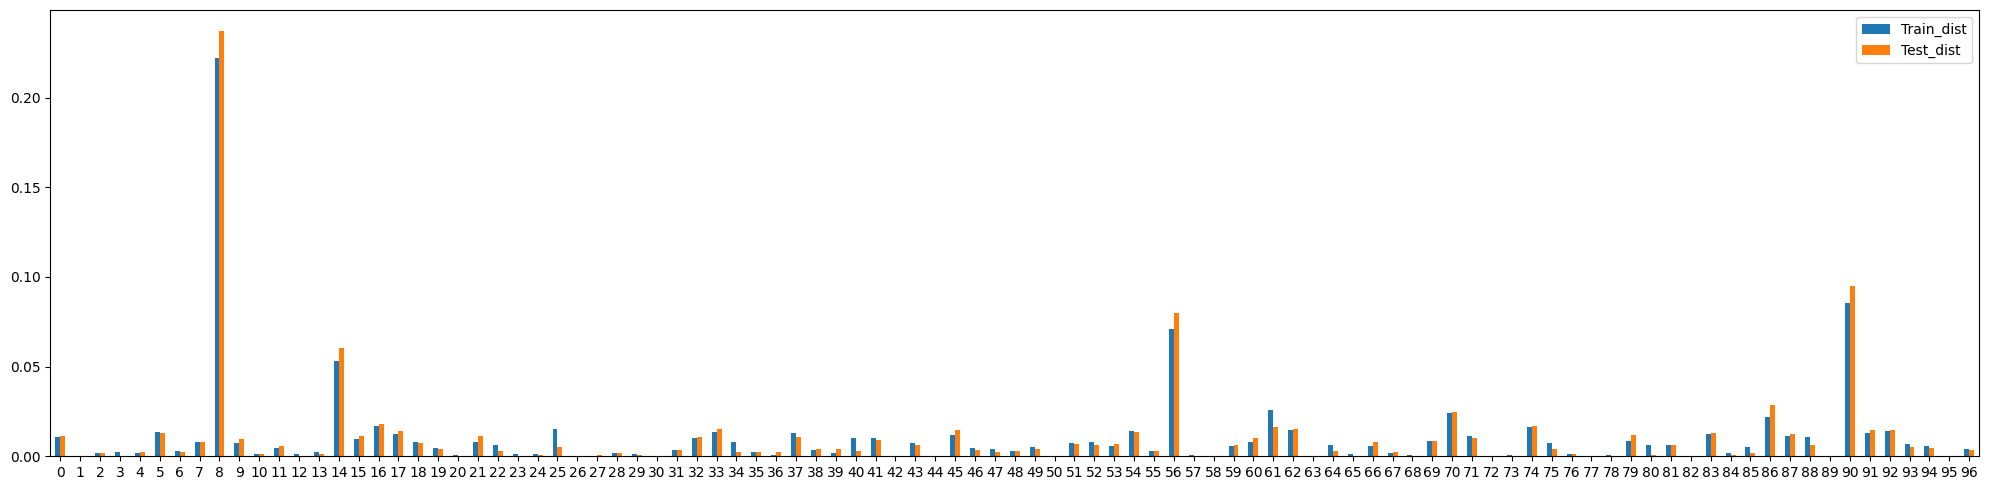

In [97]:
import matplotlib.pyplot as plt

histo.plot.bar(rot=0, figsize=(20, 5))
plt.tight_layout() # fit labels etc. nicely into the plot
plt.show()

#histo.to_csv('/home/giorgio/venvs/SHREC/prediction_on_test-train_set_comprehensive-run_08042025_122841-model_final_HISTO.csv')

,anonymised_protein_id,Run_0
0,0.vtk,39
1,1.vtk,83
2,2.vtk,8
3,3.vtk,54
4,4.vtk,43
